## Yet another implementation of genetic algorithm

There's already a good explanation here: https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3

but I'll use a different example to demonstrate how to do optimization by selecting the most fit individuals and allowing them to produce progency of potentially higher fitness at each generation.

Problem statement: given a ninja dart represented as segments, I want to write a method that draws another ninja dart as close to this star as possible. Another way to say it is that I want to minimize the distance between the new and old dart.

In [1]:
import numpy as np
from numpy import random
import pylab as pl
from matplotlib import collections  as mc

### Setting up

In [2]:
# A method to return coordinates for the segments of a dart

def make_dart(x, y):
     return [[(x, y - 1.5), (x + 0.5, y - 0.5)],
             [(x - 0.5, y - 0.5), (x, y - 1.5)],
             [(x + 0.5, y - 0.5), (x + 1.5, y)],
             [(x + 1.5, y), (x + 0.5, y + 0.5)],
             [(x + 0.5, y + 0.5), (x, y + 1.5)],
             [(x, y + 1.5), (x - 0.5, y + 0.5)],
             [(x - 0.5, y + 0.5), (x - 1.5, y)],
             [(x - 1.5, y), (x - 0.5, y - 0.5)]
            ]

In [3]:
# plot darts
from itertools import cycle
cycol = cycle('bgrcmk')

def plot_darts(darts, colors=None):
    fig, ax = pl.subplots()
    if not colors:
        colors = [random.rand(3,) for _ in darts]
    for dart, color in zip(darts, colors):
        lc = mc.LineCollection(dart, linewidths=2, color=color)
        ax.add_collection(lc)
    ax.plot()
    pl.xlim((-5, 5))
    pl.ylim((-5, 5))
    pl.gca().set_aspect('equal', adjustable='box')

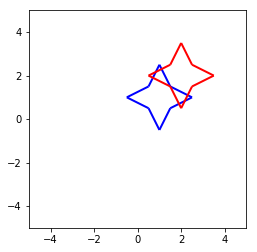

In [4]:
dart1 = make_dart(1, 1)
dart2 = make_dart(2, 2)
plot_darts([dart1, dart2], colors=['blue', 'red'])

Workflow of genetic algorithm:

```
1. Generate population randomly
<-------->
<+++----->
<---+---->
<++++++++>
...

2. Calculate fitness for each chromosome in the population
<--------> 193
<+++-----> 12
<---+----> 34
<++++++++> 392
...

3. Pick top individuals
<--------> 193
<++++++++> 392

4. crossover to get two children. This generates the next population
<---+++++>
<+++----->
...

5. Calculate fitness again
<---+++++> 422
<+++-----> 235

Go back to 2 and repeat
```

You might notice that there's a reduction in population in step 4, but above graph is a simplified representation. In implementation, we take multiple combinations of the best
fit parents to produce many children until the population size is the same as previous
generation.

### Now, write a function to produce a random chromosome
Here instead of making a dart, just draw 8 segments randomly. They don't even need to be connected to each other. Also write a method to create a population of chromosomes.

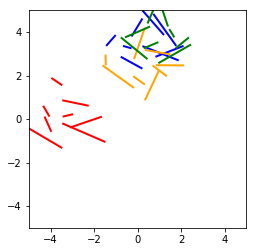

In [5]:
from numpy import random

def make_chromosome():
    x, y = -4 + 8 * random.random(), -4 + 8 * random.random()
    return [[(x, y - 2 * random.random()), (x + 2 * random.random(), y - 2 * random.random())],
             [(x - 2 * random.random(), y - 0.5), (x, y - 2 * random.random())],
             [(x + 2 * random.random(), y - 0.5), (x + 2 * random.random(), y)],
             [(x + 2 * random.random(), y), (x + 0.5, y + 2 * random.random())],
             [(x + 2 * random.random(), y + 0.5), (x, y + 2 * random.random())],
             [(x, y + 2 * random.random()), (x - 0.5, y + 2 * random.random())],
             [(x - 2 * random.random(), y + 0.5), (x - 2 * random.random(), y)],
             [(x - 2 * random.random(), y), (x - 0.5, y - 2 * random.random())]
            ]

def make_population(size=100):
    return [make_chromosome() for _ in range(size)]

plot_darts(make_population(size=4),
           ['blue', 'red', 'orange', 'green'])

### Next, define fitness function

as distance between the original dart and the input segments. For simplicity, simply sum up euclidean distance between the points.

In [6]:
from scipy.spatial.distance import cdist
from copy import deepcopy

dart = make_dart(1, 1)

def distance(p1, p2):
    # distance between two points
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

def fitness(chromosome):
    dist = 0
    list1 = deepcopy(dart)
    list2 = deepcopy(chromosome)
    list1.sort(key=lambda x: x[0])
    list2.sort(key=lambda x: x[0])
    for i in range(8):
        dist += distance(list1[i][0], list2[i][0])
        dist += distance(list1[i][1], list2[i][1])
    return dist
fitness(dart2)

22.62741699796953

## READY, first population

[40.666787609293785, 45.670299596809585, 82.28526328078193, 54.44839135656313, 59.7893497391738, 48.942168138652235, 37.291500819971255, 25.956759623441698, 27.60023418787563, 22.21189442824818]


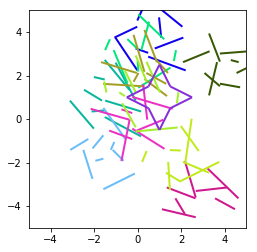

In [7]:
population = make_population(10)
population_fitness = [(chromosome, fitness(chromosome)) for chromosome in population]
print([f[1] for f in population_fitness])
plot_darts(population + [dart])

### Then we take the top.

Here, best fit = minimal fitness function value for the set up of this problem

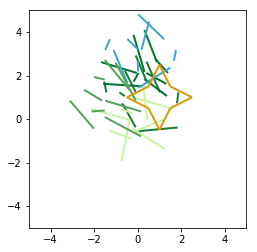

In [8]:
population_fitness.sort(key=lambda x: x[1])
best = [p[0] for p in population_fitness][:5]
plot_darts(best + [dart])

### Generate next population
by crossing over the top parents

In [ ]:
def crossover(ch1, ch2):
    """
    For each gene, pick randomly whether it is from dad or mom
    """
    new_chromosome = []
    for i in range(8):
        if random.random() < 0.5:
            new_chromosome.append(ch1[i])
        else:
            new_chromosome.append(ch2[i])
    return new_chromosome

In [ ]:
new_population = []
for _ in range(10):
    # pick two parents randomly
    idx1, idx2 = random.choice(len(best), 2, replace=False)
    parent1, parent2 = best[idx1], best[idx2]
    new_population.append(crossover(parent1, parent2))

Not perfect, but the new generation is not as spreaded over as the first population

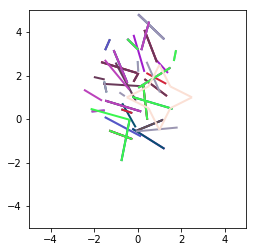

In [ ]:
plot_darts(new_population + [dart])

Let's then evolve over a few generations

In [ ]:
n_iter = 10

current_genration = best

for i in range(n_iter):
    population_fitness = [(chrom, fitness(chrom)) for chrom in current_genration]
    population_fitness.sort(key=lambda x: x[1])
    best = [p[0] for p in population_fitness][:5]

    new_population = []
    for _ in range(10):
        # pick two parents randomly
        idx1, idx2 = random.choice(len(best), 2, replace=False)
        parent1, parent2 = best[idx1], best[idx2]
        new_population.append(crossover(parent1, parent2))
    current_genration = new_population

The population converges to one solution, i.e. local optimal. Several factors affect how far it is from the actual optimal:

1. How good is the original population?
2. Number of iterations
3. How genetic contents are passed from one to the next generation. In this example, only a simple crossover operation is performed

and many many more

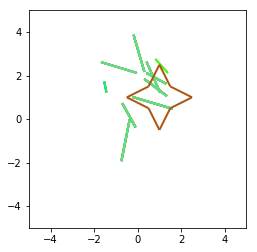

In [ ]:
plot_darts(current_genration + [dart])

## Bonus

Let's put everything together and do some clean up, to make it easier to test a few scenarios

We write a function `evolve` that does a few iterations of evolution and a function `optimize`
that allows you to specify population size and the number of generations.

Lastly, a method `test` to run optimization and then plot the optimization result along with
the original dart.

In [ ]:
def evolve(initial_population, n_iter):
    population_size = len(initial_population)
    current_generation = initial_population
    for i in range(n_iter):
        population_fitness = [(chrom, fitness(chrom)) for chrom in current_generation]
        population_fitness.sort(key=lambda x: x[1])
        best = [p[0] for p in population_fitness][:int(population_size / 4)]

        new_population = []
        for _ in range(population_size):
            # pick two parents randomly
            idx1, idx2 = random.choice(len(best), 2, replace=False)
            parent1, parent2 = best[idx1], best[idx2]
            new_population.append(crossover(parent1, parent2))
        current_generation = new_population
    return current_generation
    
def optimize(population_size, n_iter):
    initial_population = make_population(population_size)
    last_generation = evolve(initial_population, n_iter)
    population_fitness = [(chrom, fitness(chrom)) for chrom in last_generation]
    population_fitness.sort(key=lambda x: x[1])
    return population_fitness[0]

In [ ]:
def test(pop_size, n_iter):
    new_dart = optimize(pop_size, n_iter)
    plot_darts([new_dart[0], dart], colors=['blue', 'red'])

### Then run different combinations of population size and number of generations

Note that since this method is stochastic, if you run this notebook again, it's almost impossible to get the same results. Also there's no guarantee that larger population
and number of iterations will produce better results. They may or may not. In practice,
it takes a lot of experimentation to find the most suitable implementation for the
problem you are interested in.

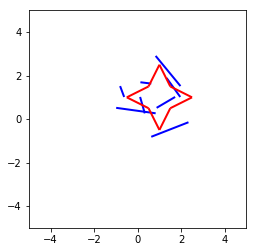

In [ ]:
test(10, 10)

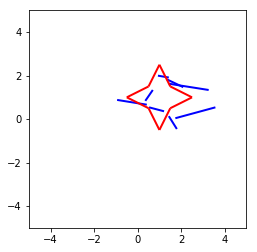

In [ ]:
test(100, 10)

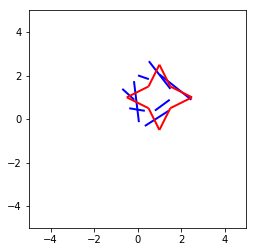

In [ ]:
test(100, 50)

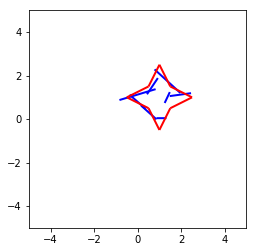

In [ ]:
test(500, 50)

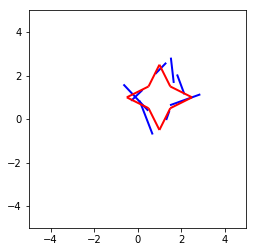

In [ ]:
test(1000, 10)

In [ ]:
test(1000, 30)